<a href="https://colab.research.google.com/github/Adasyam31494/Generative-AI-with-Large-Language-Models/blob/main/Progressive_Growing_Generative_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [14]:
class PixelNormalization(layers.Layer):
    def call(self, inputs):
        return inputs / tf.sqrt(tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True) + 1e-8)

In [15]:
def build_generator(resolution=(8, 8), latent_dim=100):
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(latent_dim,)))
    model.add(layers.Dense(256 * 4 * 4))
    model.add(layers.Reshape((4, 4, 256)))
    model.add(PixelNormalization())
    model.add(layers.Conv2D(256, kernel_size=3, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(PixelNormalization())

    if resolution[0] >= 8:
        model.add(layers.UpSampling2D())
        model.add(layers.Conv2D(128, kernel_size=3, padding='same'))
        model.add(layers.LeakyReLU(0.2))
        model.add(PixelNormalization())

    if resolution[0] >= 16:
        model.add(layers.UpSampling2D())
        model.add(layers.Conv2D(64, kernel_size=3, padding='same'))
        model.add(layers.LeakyReLU(0.2))
        model.add(PixelNormalization())

    model.add(layers.Conv2D(3, kernel_size=1, activation='tanh'))
    return model

In [16]:
def show_generated_images(images, title="Generated Faces"):
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.axis("off")
        plt.imshow((images[i] + 1) / 2)  # [-1, 1] → [0, 1]
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


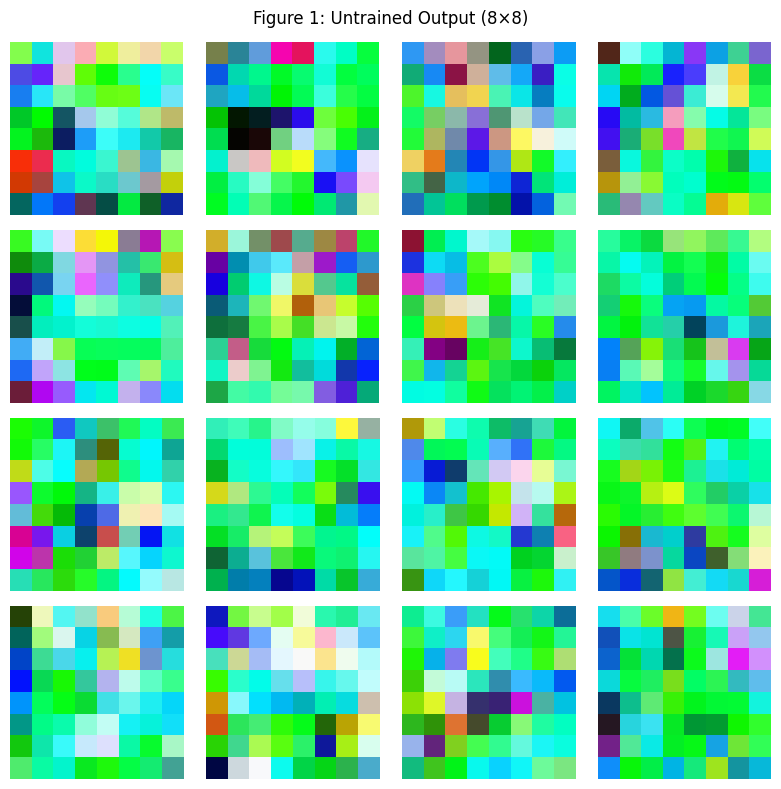

In [17]:
latent_dim = 100
generator = build_generator((8, 8), latent_dim)
latent_vectors = np.random.randn(16, latent_dim)
generated_images = generator.predict(latent_vectors)

show_generated_images(generated_images, "Figure 1: Untrained Output (8×8)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


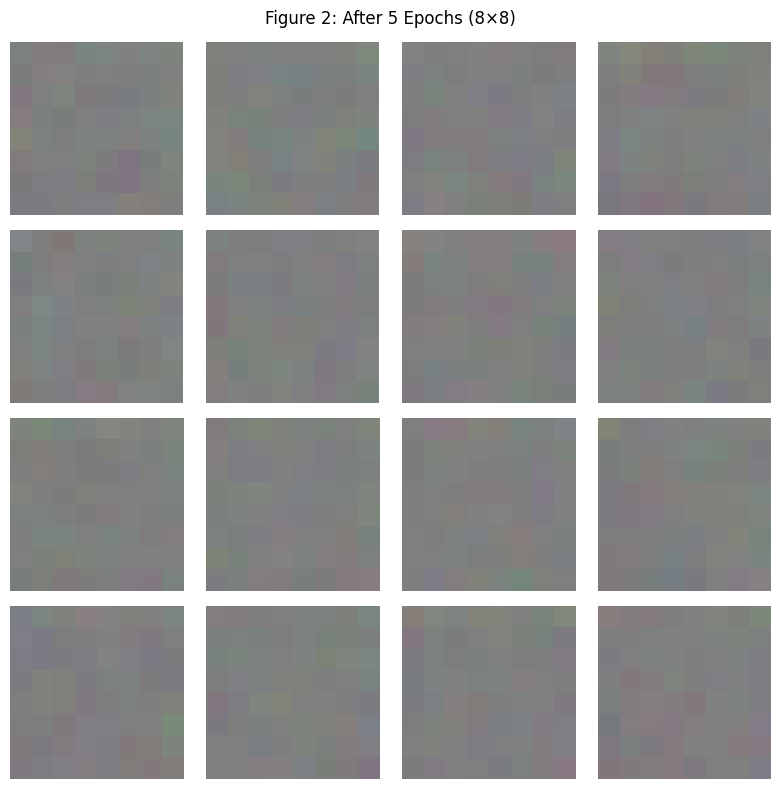

In [18]:
def train_generator(generator, latent_dim, epochs=5, batch_size=64):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss_fn = tf.keras.losses.MeanSquaredError()

    for epoch in range(epochs):
        for _ in range(100):
            noise = np.random.randn(batch_size, latent_dim)
            fake_images = generator(noise, training=True)
            target = tf.random.uniform(shape=(batch_size, *fake_images.shape[1:]), minval=-1, maxval=1)
            with tf.GradientTape() as tape:
                predictions = generator(noise, training=True)
                loss = loss_fn(target, predictions)
            grads = tape.gradient(loss, generator.trainable_variables)
            optimizer.apply_gradients(zip(grads, generator.trainable_variables))

train_generator(generator, latent_dim, epochs=5)

trained_images = generator.predict(latent_vectors)
show_generated_images(trained_images, "Figure 2: After 5 Epochs (8×8)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


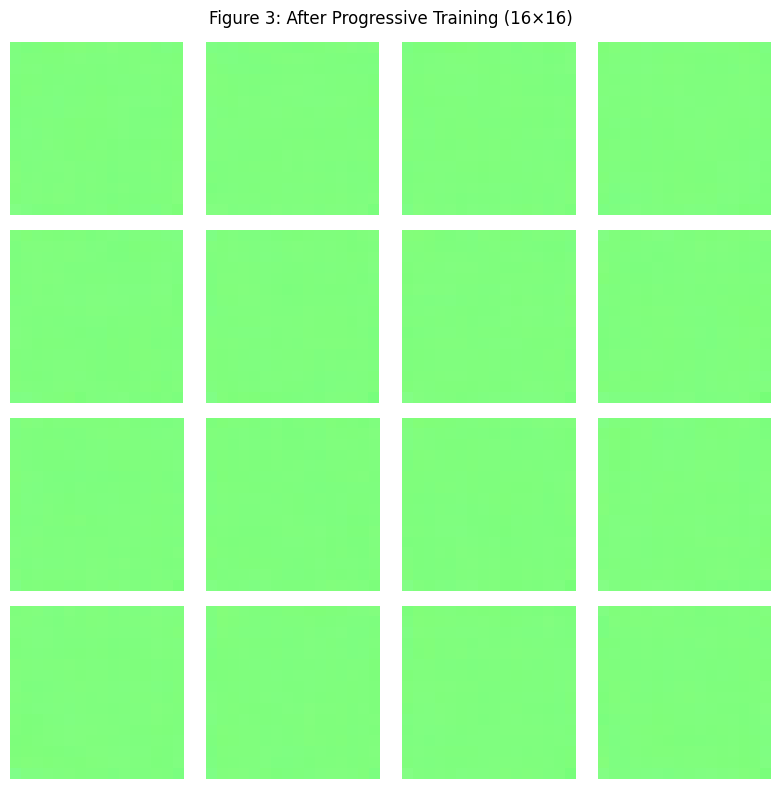

In [19]:
generator_16 = build_generator((16, 16), latent_dim)
train_generator(generator_16, latent_dim, epochs=5)

progressive_images = generator_16.predict(latent_vectors)
show_generated_images(progressive_images, "Figure 3: After Progressive Training (16×16)")